In [7]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import torch

/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


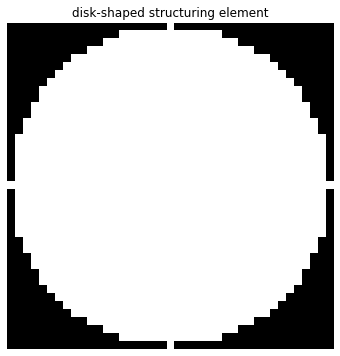

In [72]:
se = disk(20)  # radius=20
plt.figure(figsize=(6,6))
plt.imshow(se, cmap='gray')
plt.title('disk-shaped structuring element')
plt.axis('off')
plt.show()

In [73]:
b = [se for i in range(1000)]

In [74]:
c = np.array(b)

In [75]:
c.shape

(1000, 41, 41)

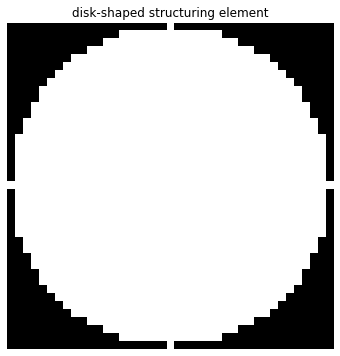

In [76]:
plt.figure(figsize=(6,6))
plt.imshow(c[5], cmap='gray')
plt.title('disk-shaped structuring element')
plt.axis('off')
plt.show()

In [77]:
ori1 = np.array([0.,0.,0.])
sp1 = np.array([1.,1.,1.])
fpath1 = 'results/cylinder_sp1.mha'
save_itk(fpath1, c, ori1, sp1)

In [78]:
ori2 = ori1
sp2 = np.array([20.,20.,20.])
fpath2 = 'results/cylinder_sp2.mha'
save_itk(fpath2, c, ori2, sp2)

In [79]:
image1_itk = itk.imread(fpath1)
skeleton1_itk = itk.MedialThicknessImageFilter3D.New(image1_itk)
itk.imwrite(skeleton1_itk, fpath1.replace('.mha', '_skeleton_itk.mha'))


image1_sitk = sitk.ReadImage(fpath1)
image1_np = sitk.GetArrayFromImage(image1_sitk)
skeleton1_ski = skeletonize_3d(image1_np)
save_itk(fpath1.replace('.mha', '_skeleton_ski.mha'), skeleton1_ski, ori1, sp1)

Downcasting int16 to uint8 without scaling because max value 1 fits in uint8


In [80]:
image2_itk = itk.imread(fpath2)
skeleton2_itk = itk.MedialThicknessImageFilter3D.New(image2_itk)
itk.imwrite(skeleton2_itk, fpath2.replace('.mha', '_skeleton_itk.mha'))

image2_sitk = sitk.ReadImage(fpath2)
image2_np = sitk.GetArrayFromImage(image2_sitk)
skeleton2_ski = skeletonize_3d(image2_np)
save_itk(fpath2.replace('.mha', '_skeleton_ski.mha'), skeleton2_ski, ori2, sp2)

In [81]:
skeleton2_ski.shape

(1000, 41, 41)

In [82]:
x,y,z = skeleton2_ski.shape

In [83]:
xs, ys, zs = np.mgrid[:x, :y, :z]

In [84]:
out = np.column_stack((xs.ravel(),ys.ravel(),zs.ravel(), skeleton2_ski.ravel()))

In [85]:
out


array([[  0,   0,   0,   0],
       [  0,   0,   1,   0],
       [  0,   0,   2,   0],
       ...,
       [999,  40,  38,   0],
       [999,  40,  39,   0],
       [999,  40,  40,   0]])

In [86]:
out2=np.array([i for i in out if i[-1]>0])

In [87]:
out2

array([[ 13,  20,  20,   1],
       [ 14,  20,  20,   1],
       [ 15,  20,  20,   1],
       ...,
       [984,  20,  20,   1],
       [985,  20,  20,   1],
       [986,  20,  20,   1]])

# Vessel skeletonization

In [ ]:
from multiprocessing import Pool, Queue, Process, Value, Array, Manager, Lock
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import itk
import SimpleITK as sitk
from tqdm import tqdm

def skeleton(file_q, process_lock):
    while True:
        file = None
        with process_lock:
            if not file_q.empty():
                file = file_q.get()
        if file:
            pass
        else:
            break

def skeleton_vessel(file_fpath, out_fpath):
    itkimage = itk.imread(file_fpath)
    # itkimage = sitk.ReadImage(file_fpath)
    print(file_fpath)
    skeleton = itk.MedialThicknessImageFilter3D.New(itkimage)
    itk.imwrite(skeleton, out_fpath)

    
    # img, ori, sp = load_itk(file_fpath, require_ori_sp=True)
    # skeletonize_3d(img)

def main():
    vessel_HR_ls = sorted(glob("/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_0422335.mha"))
    # vessel_HR_ls = ["/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_0422335.mha",
    # "/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_0456204.mha",
    # "/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_6216723.mha",
    # "/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_6318939.mha"]
    vessel_skeleton_ls = [i.replace('.mha', '_skeleton.mha') for i in vessel_HR_ls]
    print(len(vessel_HR_ls))
    pool = Pool(processes=4)

    for source, target in zip(vessel_HR_ls, vessel_skeleton_ls):
        # skeleton_vessel(source, target)
        pool.apply_async(skeleton_vessel, args=(source, target, ))
    pool.close()
    pool.join()
    print('finish')

main()

# Convert vessel skeleton to point cloud type: list of cooridanates and radius

In [7]:
from glob import glob
from tqdm import tqdm

In [8]:
vessel_skeleton_ls = glob('/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_*_skeleton.mha')


In [9]:
len(vessel_skeleton_ls)

333

## Run all images

In [8]:
for skeleton_fpath in tqdm(vessel_skeleton_ls):
    if not os.path.exists(skeleton_fpath.replace('.mha', '_coordinates.pt')):
        skeleton, ori, sp = load_itk(skeleton_fpath, require_ori_sp=True)
        x,y,z = skeleton.shape
        xs, ys, zs = np.mgrid[:x, :y, :z]
        out = np.column_stack((xs.ravel(),ys.ravel(),zs.ravel(), skeleton.ravel()))
        out2= out[out[:, -1]>0]
        out_dt = {'data': out2, 'origin':ori, 'spacing':sp}
        pickle.dump(out_dt, open(skeleton_fpath.replace('.mha', '_coordinates.pt'), "wb"))

        # np.save(skeleton_fpath.replace('.mha', '_coordinates.npy'), out2)

100%|██████████| 4/4 [00:51<00:00, 12.80s/it]


In [10]:
len_ls = []
for skeleton_fpath in tqdm(vessel_skeleton_ls):
    pth = skeleton_fpath.replace('.mha', '_coordinates.pt')
    with open(pth, 'rb') as f:
        data_dt = pickle.load(f)
    a = len(data_dt['data'])
    # print(a)
    len_ls.append(a)



100%|██████████| 333/333 [00:05<00:00, 56.31it/s]


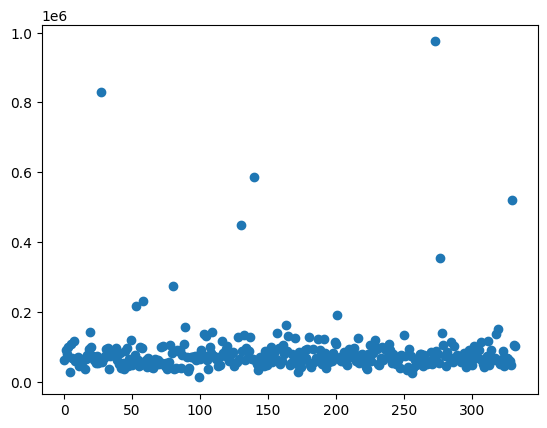

In [11]:
plt.figure()
plt.scatter(x=range(len(len_ls)), y=len_ls)
plt.show()

In [12]:
sorted(len_ls)[::-1][:20]

[974385,
 829135,
 587528,
 519476,
 450324,
 354677,
 273243,
 231410,
 217551,
 192917,
 162560,
 158006,
 150815,
 142853,
 141590,
 140242,
 139527,
 137727,
 137294,
 134395]

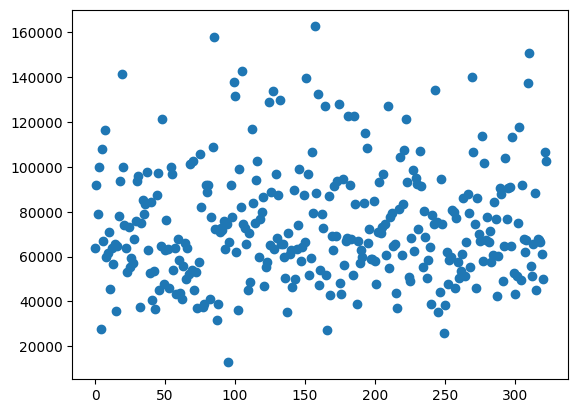

In [13]:
len_ls_remove10highest = [i for i in len_ls if i < 170000]
plt.figure()
plt.scatter(x=range(len(len_ls_remove10highest)), y=len_ls_remove10highest)
plt.show()

## Resample image to align input for PointNet
I decided to select 120,000 as the number of points for all input images.
So I need to upsample the majority of images to over 120,000 points then do some sampling (keep the original voxels!).

**A challenge is that there is still some space to improve for the vessel segmentation results (remove fissures, remove noises, etc). If the vessel segmentation results were updated in the future, should I re-calculate the skeleton (20 mins per CT), save the results, re-upsampling (3 mins per CT) the skeleton results, save their results, and re-train the network?**

No, I proposed a new and simple method to solve this issue efficiently.

In [1]:
import numpy as np
import pickle
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import time


def interpolate(coor_all: np.ndarray, img: np.ndarray, target_points: int) -> np.ndarray:
    need_point_nb = target_points - len(coor_all)
    # print('needed points', need_point_nb)
    factor = target_points //len(coor_all) + 1
    added_point_ls = []
    for coor in coor_all:
        # print(len(added_point_ls))
        if len(added_point_ls) < need_point_nb:
            tmp_ls = interpolate_once(coor, img, factor)
            added_point_ls.extend(tmp_ls)
        else:
            break
        
    added_points = np.array(added_point_ls)
    assert len(added_points.shape) == len(coor_all.shape)
    assert added_points.shape[1] == coor_all.shape[1]
    out = np.concatenate((coor_all, added_points))
    return out


def interpolate_once(coor: np.ndarray, skl: np.ndarray, factor: int) -> list:
    """
    We only do linear interpolation between two "positive" voxels.
    """
    assert factor>=1

    added_ls = []
    z, y, x = int(coor[0]), int(coor[1]), int(coor[2])

    pos_coor = np.argwhere(skl[z:z+2, y:y+2, x:x+2]>0)   # if there is any neighboring positive values, do the interpolation
    # convert the relative cooridate to global one
    pos_coor += np.array([z,y,x])
     
    if len(pos_coor)>1:
        for i in pos_coor[1:]:
            # print('i', i)
            # print('zyx',z,y,x)
            # print(skl.shape)
            coor_change = (pos_coor[0] - i) / factor  # if only need 1 interpolation
            r_change = (skl[z,y,x] - skl[tuple(i)]) / factor
            for j in range(1, factor):  # two times means insert one value for each voxel
                if coor[0]%1!=0 or coor[1]%1!=0 or coor[2]%1!=0:
                    tmp = np.append(i + coor_change * j * 0.5, skl[tuple(i)] + r_change * j * 0.5)
                else:
                    tmp = np.append(i + coor_change * j, skl[tuple(i)] + r_change * j)
                added_ls.append(tmp) 
    return added_ls




skl_cord_ls = sorted(glob('/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_???????_skeleton_coordinates.pt'))
skl_ls = sorted(glob('/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_???????_skeleton.mha'))
llss = []
for skl_img, skl_cord_np in tqdm(zip(skl_ls, skl_cord_ls)):
    # if '0422335' in skl_img or '0456204' in skl_img or '6216723' in skl_img or '6318939' in skl_img:
    print(skl_img)
    tmp = skl_cord_np
    with open(tmp, 'rb') as handle:
        a = pickle.load(handle)

    x = a['data']
    # print('x len', len(x))
    np.take(x,np.random.permutation(x.shape[0]),axis=0,out=x)

    skl, ori, sp = load_itk(skl_img, require_ori_sp=True)

    tt = time.time()
    if len(x)<140000:
        new_coor_all = interpolate(coor_all=x, img=skl, target_points=140000) 
        # print('total points',len(new_coor_all))
        if len(new_coor_all)<140000:  # second interpolation !!
            print(f'{skl_cord_np} original point number: {len(x)}, first intplt: {len(new_coor_all)}')
            new_coor_all = interpolate(coor_all=new_coor_all, img=skl, target_points=140000) 
            print(f"second intplt: {len(new_coor_all)}")
        if len(new_coor_all)<140000:  # third interpolation !!
            new_coor_all = interpolate(coor_all=new_coor_all, img=skl, target_points=140000) 
            print(f"third intplt: {len(new_coor_all)}")
        if len(new_coor_all)<140000:
            raise Exception(f"Why?!")

        tt2 = time.time()
        a['data'] = new_coor_all
    else:
        print(f"{skl_cord_np} has over 140000 points, it is {len(x)}")
    llss.append(new_coor_all)
    pickle.dump(a,open(f"{skl_cord_np.replace('.pt', '140000.pt')}", 'wb'))
        # print('time cost', tt2-tt)
print('finished')


/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
0it [00:00, ?it/s]

/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_0422335_skeleton.mha


22it [00:02,  8.60it/s]

/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_0456204_skeleton.mha


23it [00:06,  2.93it/s]

/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_6216723_skeleton.mha


204it [00:09, 27.60it/s]

/home/jjia/data/dataset/lung_function/ori_resolution/SSc_patient_6318939_skeleton.mha


333it [00:12, 27.38it/s]

finished


In [17]:
len_ls_ori = []
for skeleton_fpath in tqdm(vessel_skeleton_ls):
    pth = skeleton_fpath.replace('.mha', '_coordinates.pt')
    with open(pth, 'rb') as f:
        data_dt = pickle.load(f)
    a = len(data_dt['data'])
    # print(a)
    len_ls_ori.append(a)

len_ls = []
for skeleton_fpath in tqdm(vessel_skeleton_ls):
    pth = skeleton_fpath.replace('.mha', '_coordinates140000.pt')
    with open(pth, 'rb') as f:
        data_dt = pickle.load(f)
    a = len(data_dt['data'])
    # print(a)
    len_ls.append(a)


100%|██████████| 333/333 [00:01<00:00, 232.32it/s]


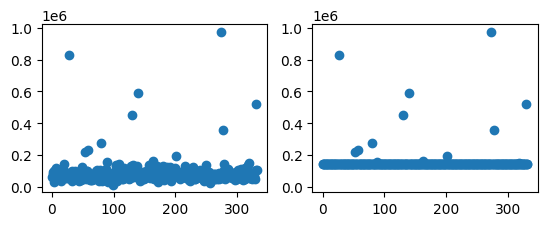

In [20]:
plt.figure()
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(x=range(len(len_ls_ori)), y=len_ls_ori)
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(x=range(len(len_ls)), y=len_ls)
ax2.sharey(ax1)
plt.show()
